Final Project - Big Ten Softball (Michigan Focus)

Partners: Shannon Li and Katelyn Lawton

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy import stats

Data Sources

In [2]:
pitching = pd.read_csv('michigan2021softballpitching.csv')
fielding = pd.read_csv('michigan2021softballfielding.csv')
hitting_game_by_game = pd.read_csv('mgoblue_data.csv')

Data Cleaning

In [3]:
def name_fix(name):
    split_name = name.strip().split()
    if len(split_name) == 1:
        return name.strip()
    else:
        if ',' in split_name[0]:
            return name.strip()
        else:
            return split_name[1] + ', ' + split_name[0]

hitting_game_by_game['Player'] = hitting_game_by_game['Player'].apply(name_fix)

In [4]:
def fix_position(pos):
    if pos == None:
        return None
    else:
        split_pos = pos.split('/')
        if len(split_pos) == 1:
            return pos
        else:
            if split_pos[0] in ['DP', 'PH', 'PR']:
                if split_pos[1] in ['DP', 'PH', 'PR']:
                    return split_pos[0]
                else:
                    return split_pos[1]
            elif split_pos[1] in ['DP', 'PH', 'PR']:
                return split_pos[0]
            else:
                return split_pos[0]
        
    
hitting_game_by_game['Position'] = hitting_game_by_game['Position'].apply(fix_position)

Merged DatFrames

In [5]:
hitting_fielding = pd.merge(hitting_game_by_game, fielding, how='left', on='Player')
everything = pd.merge(hitting_fielding, pitching, how='left', on='Player')

Clean up merged dataframe

In [6]:
everything = everything.rename(columns={'AB_x': 'at_bats', 'R_x':'runs', 'H_x': 'hits', 'RBI': 'RBI', '2B_x': '2B', '3B_x': '3B',
                           'HR_x': 'homeruns', 'BB_x': 'base_on_balls', 'SB': 'sac_bunt', 'CS': 'caught_stealing', 
                           'HBP_x':'hit_by_pitch', 'SH': 'sac_hits', 'SF': 'sac_fly', 'SO_x': 'strikeouts', 
                           'KL': 'strikeouts_looking', 'GDP': 'ground_into_double', 'PO_x': 'putout', 
                           'A_x':'hitting_assists', 'PO_y': 'fielding_putouts', 'A_y': 'fielding_assists', 
                           'E': 'errors', 'FLD%': 'fielding_%', 'DP': 'double_play', 'SBA': 'stolen_bases_allowed',
                           'PB': 'passed_balls', 'ERA': 'earned_run_average', 'W-L':'win_loss', 
                           'GP-GS': 'gamespitched_gamesstarted', 'CG': 'completed_game', 'SHO': 'shutout', 
                           'SV': 'save', 'IP': 'innings_pitched', 'H_y': 'pitching_hits', 'R_y': 'pitching_runs', 
                           'ER': 'earned_run', 'BB_y': 'pitching_base_on_balls', 'SO_y': 'pitching_SO', 
                           '2B_y': 'pitching_2B', '3B_y': 'pitching_3B', 'HR_y': 'pitching_homeruns', 
                           'AB_y': 'pitching_at_bats', 'WP': 'wild_pitch', 
                           'HBP_y': 'pitcher_hit_by_pitch', 'BK': 'balk'})

Problem 1:
    Look at a hollistic view of two successful players on the Michigan team, and caluclate their runs scored per game using a liner weights model. The Linear Weights model uses a multiple regression of offensive statistics to calculate estimated runs scored for a specific player.

Equation: RS = -50+OFFT[0.63(1B)+0.72(2B)+1.24(3B)+1.50(HR)+0.35(BB+HBP)+0.06(SB)+0.02(CS)]
* No need to understand the equation, being able to apply the function is the improtant part

In [7]:
def batting_average(df):
    if df['AB'] == 0:
        return 0.0
    else:
        ba = df['H']/df['AB']
        return ba
    
hitting_game_by_game['batting_average'] = hitting_game_by_game.apply(batting_average, axis=1)

In [8]:
michigan_df = hitting_game_by_game[hitting_game_by_game["Team"] == "Michigan"]

In [9]:
blair = michigan_df[michigan_df["Player"] == 'Blair, Lexie']
rodriguez = michigan_df[michigan_df["Player"] == 'Rodriguez, Natalia']

In [10]:
singles = blair['H'].sum() - (blair['2B'].sum()+blair['3B'].sum()+blair['HR'].sum())
OUTSP=0.982 * (blair['AB'].sum())-blair['H'].sum()+blair['GDP'].sum()+blair['SF'].sum()+blair['SB'].sum()+blair['CS'].sum()
OFFT = (1/OUTSP) * 410
RS = -50 + OFFT * (0.63 * (singles) + 0.72 * (blair['2B'].sum()+1.24*(blair['3B'].sum())+1.50*(blair['HR'].sum())+0.35*(blair['BB'].sum()+blair['HBP'].sum())+0.06*(blair['SB'].sum())+0.02*(blair['CS'].sum())))
runs_per_game = RS/20
runs_per_game

10.536304643090698

In [11]:
singles = rodriguez['H'].sum() - (rodriguez['2B'].sum()+rodriguez['3B'].sum()+rodriguez['HR'].sum())
OUTSP=0.982 * (rodriguez['AB'].sum())-rodriguez['H'].sum()+rodriguez['GDP'].sum()+rodriguez['SF'].sum()+rodriguez['SB'].sum()+rodriguez['CS'].sum()
OFFT = (1/OUTSP) * 410
RS = -50 + OFFT * (0.63 * (singles) + 0.72 * (rodriguez['2B'].sum()+1.24*(rodriguez['3B'].sum())+1.50*(rodriguez['HR'].sum())+0.35*(rodriguez['BB'].sum()+rodriguez['HBP'].sum())+0.06*(rodriguez['SB'].sum())+0.02*(rodriguez['CS'].sum())))
runs_per_game = RS/20
runs_per_game

3.697724351344918

Comparing Lexie Blair and Natalia Rodriguez runs scored per game it can be seen that Lexie Blair has a stronger ofeensive output than Natalia Rodriguez despite Natalia being known as an effective offense output. By looking at this statistic it can bee seen that even though they are both offensively productive, Lexie Blair is better in game scenarios with runners on base

Problem 2: Comapring offensive and defensive data

In [12]:
hitting_fielding = pd.merge(hitting_game_by_game, fielding, how='right', on='Player')
michigan_hitting_fielding = hitting_fielding[hitting_fielding["Team"] == "Michigan"]

In [13]:
BA_group = michigan_hitting_fielding.groupby("game_id").agg({'batting_average': np.nanmean})

In [14]:
michigan_batting_average = list(BA_group["batting_average"])

In [15]:
FLD_group = michigan_hitting_fielding.groupby("game_id").agg({'FLD%': np.nanmean})

In [16]:
michigan_fielding_percentages = list(FLD_group["FLD%"])

In [17]:
game_id = BA_group.index

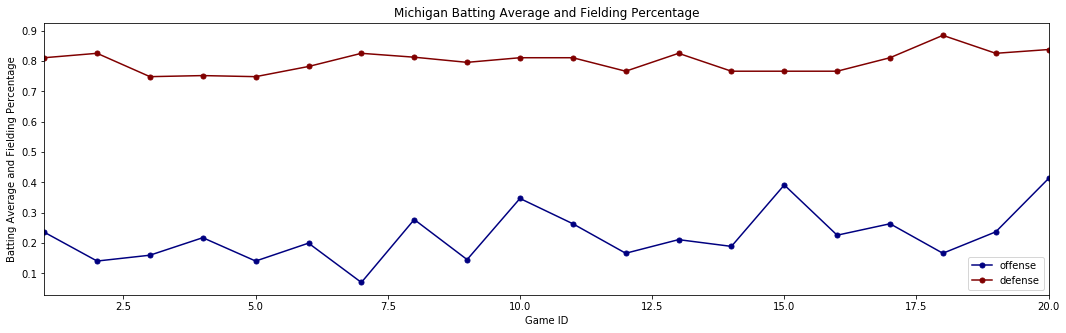

In [18]:
df = pd.DataFrame({
   'offense': michigan_batting_average,
   'defense': michigan_fielding_percentages
   }, index=game_id)

df.plot(colormap='jet', marker='.', markersize=10,figsize=(18,5), title='Michigan Batting Average and Fielding Percentage');
plt.xlabel('Game ID')
plt.ylabel('Batting Average and Fielding Percentage')
plt.show()

Problem 3: Do infield player have better BA than outfield players

In [19]:
michigan_hf = hitting_fielding[hitting_fielding['Team']=='Michigan']

In [33]:
def in_or_out(pos):
    if re.match(r'(LF|RF|CF)', pos) != None:
        return 'outfield'
    elif re.match(r'(1B|2B|3B|SS|c|P)', pos) != None:
        return 'infield'
    else:
        return 'flex'    

In [34]:
michigan_hf['in_out'] = michigan_hf['Position'].apply(in_or_out)

In [35]:
infield = michigan_hf[michigan_hf["in_out"] == "infield"]["batting_average"]
outfield = michigan_hf[michigan_hf["in_out"] == "outfield"]["batting_average"]

print(sum(infield)/infield.count())
print(sum(outfield)/outfield.count())

t_test = stats.ttest_ind(infield, outfield)
p_value = t_test.pvalue
print(p_value)

if p_value < 0.05:
    print("we reject the null hypothesis that the infield players have similar batting averages to outfielders")
else:
    print("we accept the null hypothesis that the infield players have similar batting averages to outfielders")


0.19199134199134196
0.2767156862745098
0.03926477838189622
we reject the null hypothesis that the infield players have similar batting averages to outfielders


Problem 4: Runs created

In [23]:
michigan_h = hitting_game_by_game[hitting_game_by_game['Team']=='Michigan']

In [24]:
michigan_h['TB'] = (michigan_h['H']-michigan_h['2B']-michigan_h['3B']-michigan_h['HR']) + (2*michigan_h['2B']) + (3*michigan_h['3B']) + (4*michigan_h['HR'])
michigan_h['Runs_created'] = ((michigan_h['H']+michigan_h['BB']+michigan_h['HBP'])*michigan_h['TB'])/(michigan_h['AB']+michigan_h['BB']+michigan_h['HBP'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
#to get one date, I aggegrated by average of the runs created - is that okay or would that be a problem?
grouped_michigan_h = michigan_h.groupby("Date").agg({"Runs_created":np.nanmean})
dates = grouped_michigan_h.index
runs_created_by_player_data = list(grouped_michigan_h["Runs_created"])

In [26]:
not_michigan_h = hitting_game_by_game[hitting_game_by_game['Team']!='Michigan']

In [27]:
not_michigan_h['TB'] = (not_michigan_h['H']-not_michigan_h['2B']-not_michigan_h['3B']-not_michigan_h['HR']) + (2*not_michigan_h['2B']) + (3*not_michigan_h['3B']) + (4*not_michigan_h['HR'])
not_michigan_h['Runs_created'] = ((not_michigan_h['H']+not_michigan_h['BB']+not_michigan_h['HBP'])*not_michigan_h['TB'])/(not_michigan_h['AB']+not_michigan_h['BB']+not_michigan_h['HBP'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
grouped_not_michigan_h = not_michigan_h.groupby("Date").agg({"Runs_created":np.nanmean})
dates = grouped_not_michigan_h.index
runs_created_by_player_data_not_michigan = list(grouped_not_michigan_h["Runs_created"])

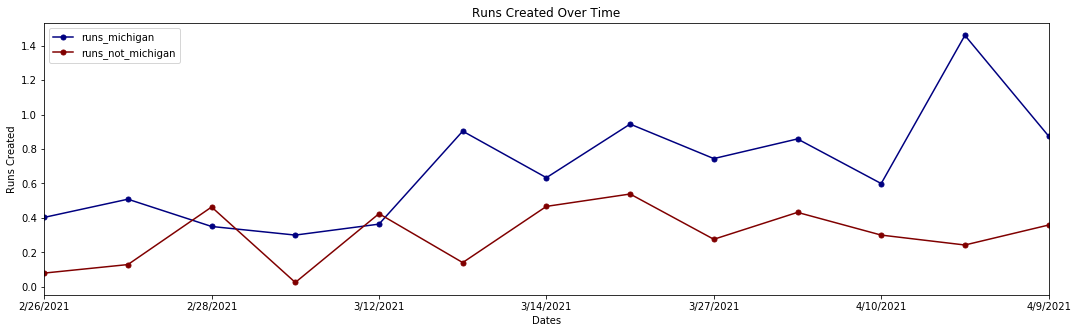

In [29]:
df = pd.DataFrame({
    'runs_michigan': runs_created_by_player_data,
    'runs_not_michigan': runs_created_by_player_data_not_michigan
   }, index=dates)

df.plot(colormap
        ='jet', marker='.', markersize=10,figsize=(18,5), title='Runs Created Over Time');
plt.xlabel('Dates')
plt.ylabel('Runs Created')
plt.show()

Problem 5: Using pivot tables to compare collective batting average of player by position for each Big Ten Team

To just wrap up with a simple problem, we wanted to looking at battnig averages across teams by position

In [30]:
piv = hitting_game_by_game.pivot_table(values='batting_average', index=['Team', 'Position'], aggfunc=[np.mean])

piv.unstack()

mean                                               \
           batting_average                                                
Position                1B        2B        3B         C        CF   DH   
Team                                                                      
Illinois          0.000000  0.458333  0.000000  0.500000  0.333333  NaN   
Indiana           0.000000  0.270833  0.300000  0.166667  0.375000  NaN   
Iowa              0.166667  0.000000  0.000000  0.166667  0.166667  NaN   
Michigan          0.313043  0.237500  0.333333  0.266667  0.384127  0.0   
Nebraska          0.000000  0.000000  0.166667  0.111111  0.166667  0.0   
Ohio State        0.208333  0.250000  0.208333  0.208333  0.125000  NaN   
Purdue            0.000000  0.000000  0.000000  0.500000  0.000000  NaN   
Wisconsin         0.000000  0.166667  0.166667  0.000000  0.777778  NaN   

                                                                             
                                                                             
Position          DP        LF    P        PH        PR        RF        SS  
Team                                                                         
Illinois    0.000000  0.166667  0.0       NaN  0.000000  0.250000  0.166667  
Indiana     0.111111  0.395833  0.0  0.000000  0.000000  0.166667  0.250000  
Iowa        0.000000  0.166667  0.0  0.000000  0.000000  0.250000  0.000000  
Michigan    0.239216  0.308333  0.0  0.214286  0.064516  0.169753  0.297500  
Nebraska    0.166667  0.166667  0.0  0.000000  0.000000  0.166667  0.000000  
Ohio State  0.250000  0.229167  0.0  0.000000  0.000000  0.166667  0.000000  
Purdue      0.000000  0.000000  0.0  0.000000  0.000000  0.166667  0.166667  
Wisconsin   0.000000  0.277778  0.0  1.000000       NaN  0.083333  0.111111

Test Cases

In [31]:
def text_name_fix():
    for name in michigan_df['Player']:
        assert len(name.split(", ")) == 2
        
def offense_and_defense():
    for count in range(len(michigan_batting_average)):
        assert michigan_batting_average[count] < michigan_fielding_percentages[count], "defense should be higher"

def test_num_dates():
    assert len(dates) == 13, "Should be 13"
    
def test_runs_created():
    for val in runs_created_by_player_data:
        assert val >= 0, "Test does not work"
        
def test_batting_average():
    for average in hitting_game_by_game['batting_average']:
        assert average >= 0.0 and average <= 1.0
        assert type(average) == float
        
def test_hitting_fielding():
    index = michigan_df.index
    number_of_rows = len(index)
    assert number_of_rows == 263
    
def test_fix_position():
    for pos in hitting_game_by_game['Position']:
        if pos != None:
            assert len(pos) == 1 or len(pos) == 2
    
if __name__ == "__main__":
#     text_name_fix()
    offense_and_defense()
    test_num_dates()
    test_runs_created()
    test_num_dates()
    test_batting_average()
    test_hitting_fielding()
    test_fix_position()
    print("Everything passed")

Everything passed
